# Configure SBS Parameters

This notebook should be used as a test for ensuring correct SBS image loading and processing before running the SBS module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [32]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [46]:
from pathlib import Path

import yaml
from tifffile import imread
import pandas as pd
from snakemake.io import expand
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.sbs.align_cycles import align_cycles
from lib.shared.log_filter import log_filter
from lib.sbs.compute_standard_deviation import compute_standard_deviation
from lib.sbs.max_filter import max_filter
from lib.sbs.find_peaks import find_peaks, find_peaks_spotiflow, plot_channels_with_peaks
from lib.shared.illumination_correction import apply_ic_field, combine_ic_images
from lib.shared.segment_cellpose import prepare_cellpose
from lib.cluster.scrape_benchmarks import get_uniprot_data
from lib.sbs.standardize_barcode_design import standardize_barcode_design, get_barcode_list
from lib.sbs.extract_bases import extract_bases
from lib.sbs.call_reads import call_reads, plot_normalization_comparison
from lib.sbs.call_cells import call_cells
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.sbs.eval_mapping import (
    plot_mapping_vs_threshold,
    plot_cell_mapping_heatmap,
    plot_cell_metric_histogram,
    plot_gene_symbol_histogram,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing SBS processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels

- `CHANNEL_NAMES`: A list of ordered names for each channel in your SBS image. 
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [48]:
# Define test well and tile
TEST_PLATE = 1
TEST_WELL = 3
TEST_TILE = 20
# Derive wildcard dictionary for testing
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# Define image channels with DAPI as the first channel
CHANNEL_NAMES = ["DAPI", "G", "T", "A", "C"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_magenta", "pure_cyan"]

# Remove DAPI channel to get bases
BASES = [channel for channel in CHANNEL_NAMES if channel in ["G", "T", "A", "C"]]
EXTRA_CHANNELS = [channel for channel in CHANNEL_NAMES if channel not in ["G", "T", "A", "C"]]

## <font color='red'>SET PARAMETERS</font>

### Alignment
- `ALIGNMENT_METHOD`: Optional. Method for aligning SBS images between cycles. If not specified, the method will be automatically selected based on available channels, but can be overridden by the user:
    - `DAPI`: the DAPI channel is used for alignment between cycles. Automatically selected if **DAPI is present in each** round of SBS imaging.
    - `sbs_mean`: the mean intensity of base channels is used for alignment between cycles. Automatically selected if **DAPI is not present in each** round of SBS imaging.
- `UPSAMPLE_FACTOR`: Factor used for subpixel alignment. Defaults to `2`
    - Higher values provide more precise alignment but increase processing time.
    - Set to `1` to disable subpixel alignment for faster processing.
- `SKIP_CYCLES`: Optional. List of cycle indices to skip during alignment. Defaults to `None`
    - Use this to exclude problematic cycles that would interfere with alignment
    - Example: `[1]` to skip the first cycle, `[1, 6]` to skip cycles 1 and 6
    - Skipped cycles are completely removed from processing and will not appear in final results
- `MANUAL_BACKGROUND_CYCLE`: Optional. Specific cycle to use as the source for segmentation background channels. Defaults to `None`
    - Use this when you have segmentation channels (e.g., DAPI, GFP) in a specific cycle that you want propagated to all cycles
    - If not specified, automatically selects the cycle with the most extra (non-GTAC) channels
    - Example: `12` to use cycle 12 as the source for background channels
    - Note: This refers to the original cycle index before any cycles are skipped

In [49]:
ALIGNMENT_METHOD = None
UPSAMPLE_FACTOR = 2
SKIP_CYCLES = None
MANUAL_BACKGROUND_CYCLE = None

Loading test images...
Aligning test images...
Final stacked shape before alignment: (4, 5, 3200, 3200)
Method not provided. Using 'DAPI' for alignment based on data structure.
Example aligned image for first cycle:


/opt/miniconda3/envs/brieflow_main_env/lib/python3.11/site-packages/microfilm/microplot.py:725: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  self.fig, self.ax = plt.subplots(


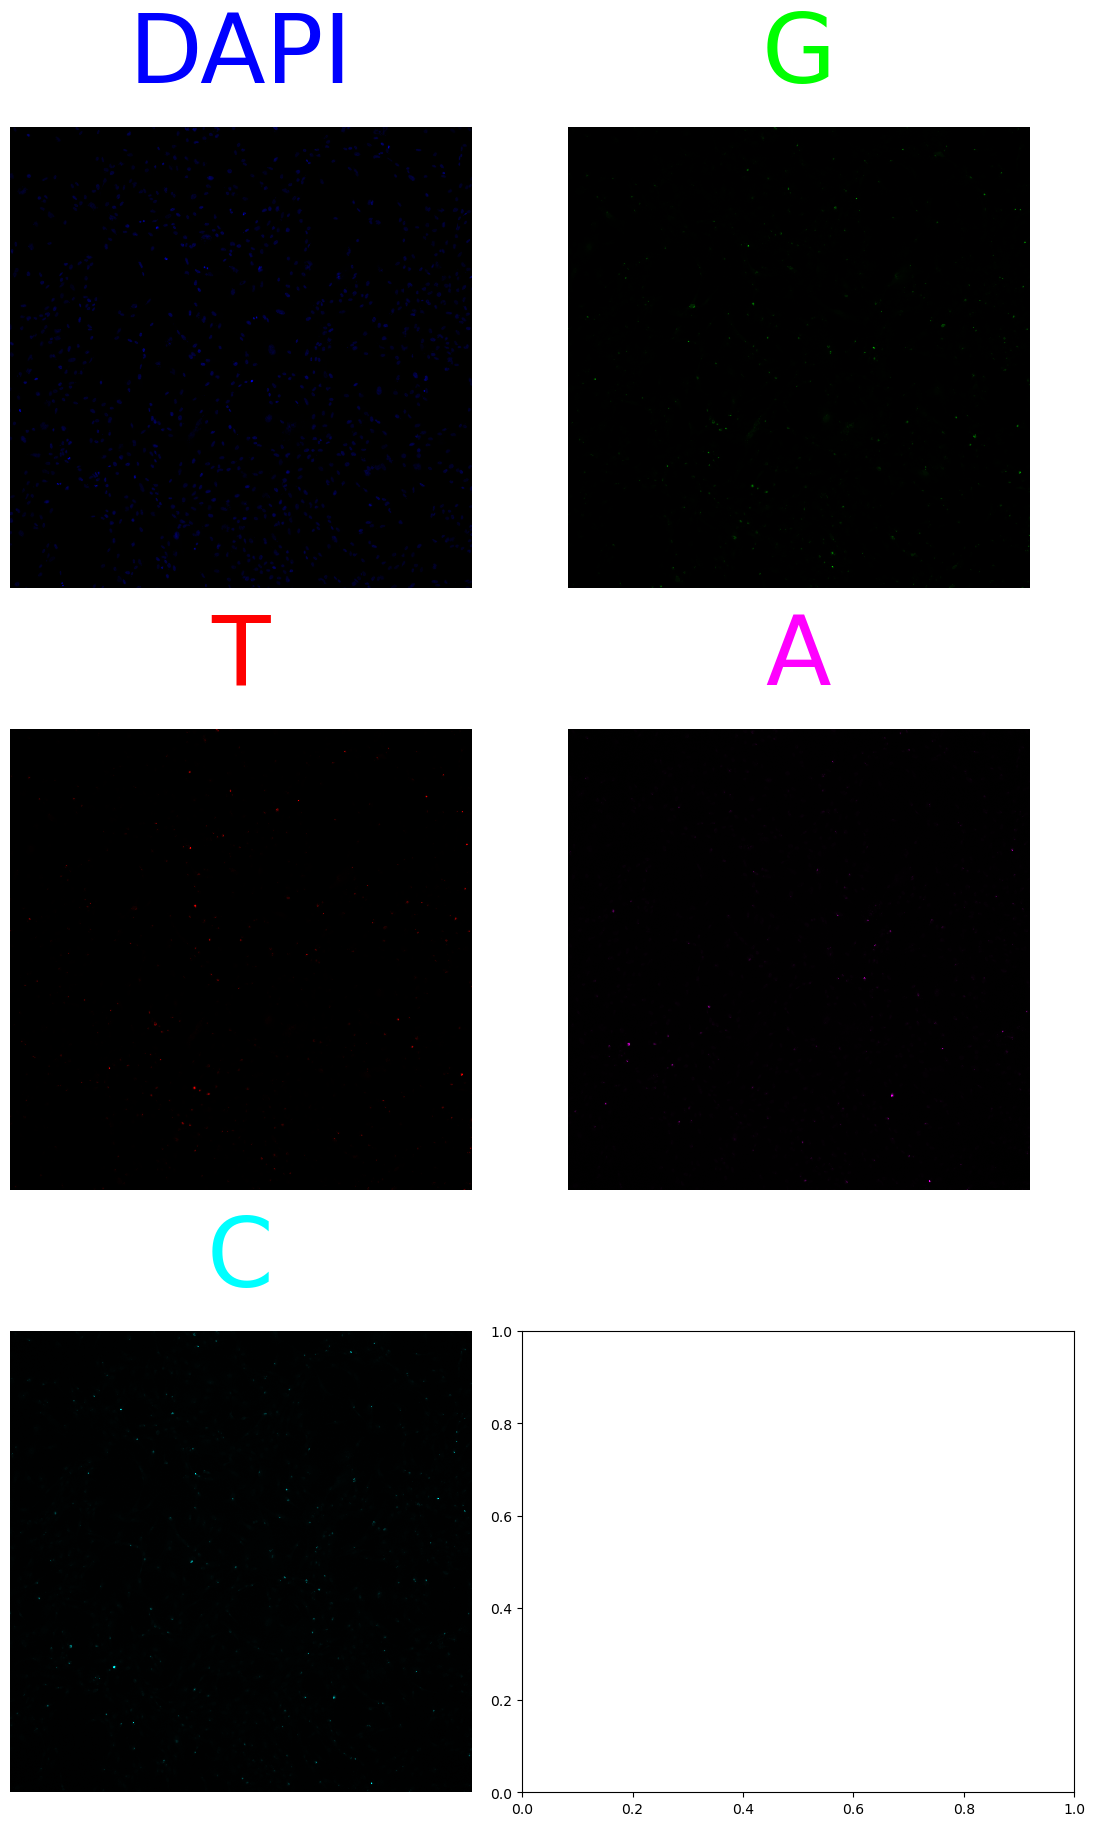

In [50]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = sorted(list(sbs_samples["cycle"].unique()))
# Define cycles for testing if not None
SKIP_CYCLES_INDICES = [SBS_CYCLES.index(c) for c in SKIP_CYCLES] if SKIP_CYCLES is not None else None
MANUAL_BACKGROUND_CYCLE_INDEX = SBS_CYCLES.index(MANUAL_BACKGROUND_CYCLE) if MANUAL_BACKGROUND_CYCLE is not None else None

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
sbs_test_image_paths = expand(
    PREPROCESS_FP
    / "images"
    / "sbs"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
        "image",
        "tiff",
    ),
    cycle=SBS_CYCLES,
)
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]

# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    channel_order=CHANNEL_NAMES,
    method=ALIGNMENT_METHOD,
    upsample_factor=1,
    skip_cycles=SKIP_CYCLES_INDICES,
    manual_background_cycle=MANUAL_BACKGROUND_CYCLE_INDEX,
)

# Create and display micropanel of aligned images
print("Example aligned image for first cycle:")
aligned_microimages = [
    Microimage(
        aligned[0, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(aligned.shape[1])
]
aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
plt.show()

# NOTE: You can also loop through all your cycles to display micropanels to be sure of alignment by uncommenting the following lines:
# for cycle_idx in range(aligned.shape[0]):  # Adjust this range if you have a different number of cycles
#     print(f"Example aligned image for cycle {cycle_idx + 1}:")
#     aligned_microimages = [
#         Microimage(
#             aligned[cycle_idx, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
#         )
#         for i in range(aligned.shape[1])
#     ]
#     aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
#     plt.show()

## <font color='red'>SET PARAMETERS</font>

### Spot detection

- `MAX_FILTER_WIDTH`: Width parameter used for determining the neighborhood size for finding local maxima. No default value, but `3` is suggested
- `SPOT_DETECTION_METHOD`: Methodology for calling spots: 
    - `STANDARD`: Standard method for calling spots, involving Laplacian of Gaussian correction, and computation of spots across cycles. Spots are identified based on signal intensity and consistency across cycles.
        - `PEAK_WIDTH`: Width parameter used for peak detection, sets neighborhood size for finding local maxima of base channels standard deviation. Defaults to `5`
    - `SPOTIFLOW`: Deep learning based methodology for calling spots. Spots are called independently on all 4 bases of a selected cycle, and then coalesced to ensure minimum distance between spots. If this method is selected, the following parameters are required:
        - `SPOTIFLOW_CYCLE_INDEX`: Cycle to use for spot detection
        - `SPOTIFLOW_MODEL`: Model to use for spot detection (e.g., "general", "hybiss")
        - `SPOTIFLOW_THRESHOLD`: Probability threshold for confidence in spot detection
        - `SPOTIFLOW_MIN_DISTANCE`: Minimum distance (in pixels) required between detected spots


In [57]:
# Set parameters:
MAX_FILTER_WIDTH = 3
SPOT_DETECTION_METHOD = "standard"

if SPOT_DETECTION_METHOD == "standard":
   PEAK_WIDTH = 5

elif SPOT_DETECTION_METHOD == "spotiflow":
   SPOTIFLOW_CYCLE_INDEX = 0
   SPOTIFLOW_MODEL = "general"
   SPOTIFLOW_THRESHOLD = 0.3         
   SPOTIFLOW_MIN_DISTANCE = 1

# Derive extra channel indices
EXTRA_CHANNEL_INDICES = [CHANNEL_NAMES.index(channel) for channel in EXTRA_CHANNELS]

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Applying max filter...
Computing standard deviation over cycles...
Finding peaks using standard method...
Example max filtered image for first cycle:


/opt/miniconda3/envs/brieflow_main_env/lib/python3.11/site-packages/microfilm/microplot.py:725: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  self.fig, self.ax = plt.subplots(


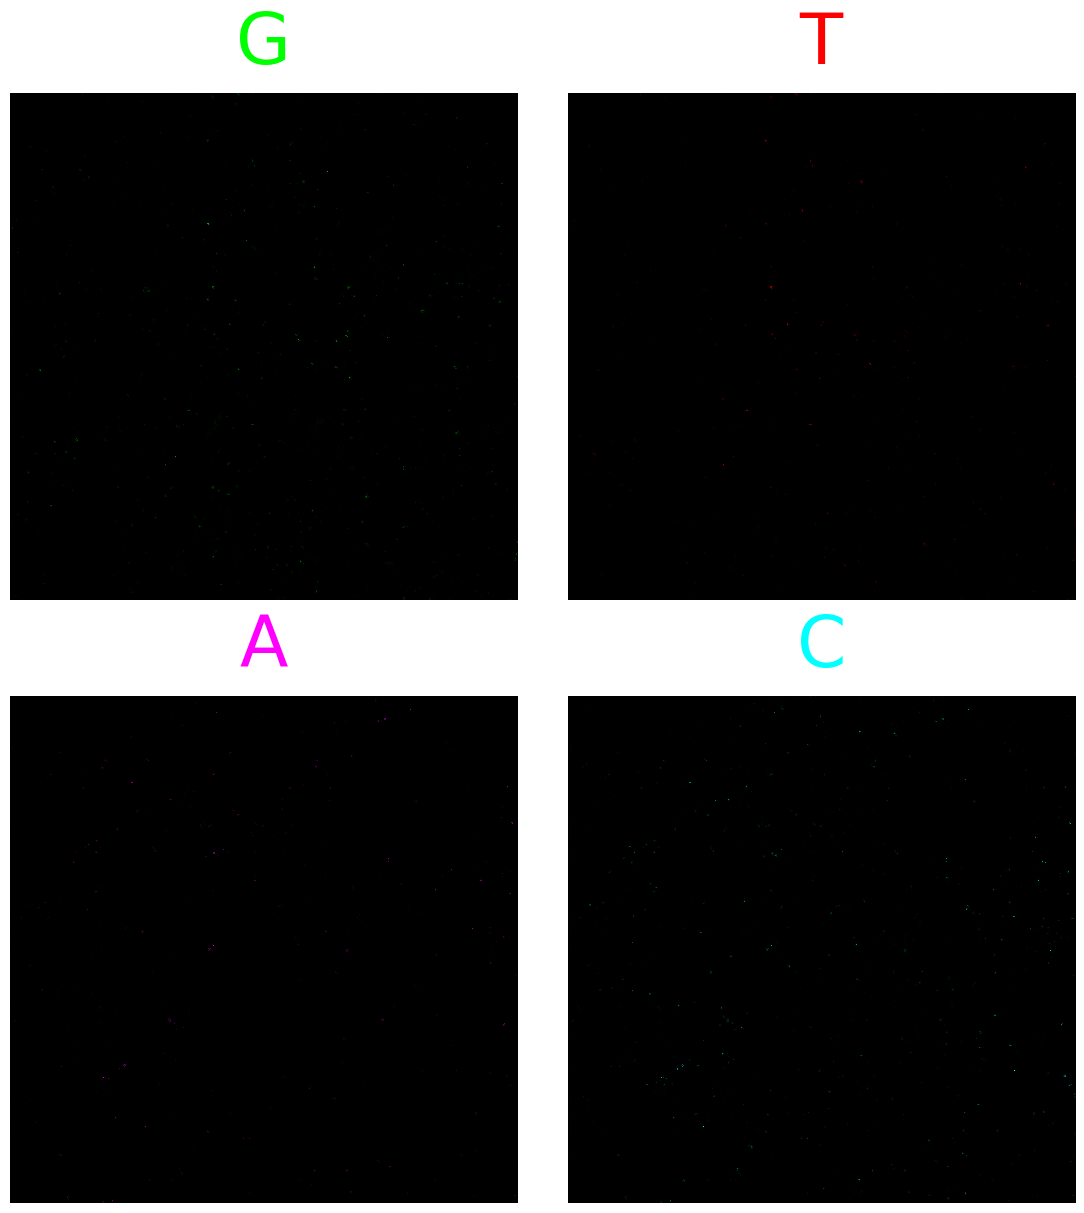

Found 3372 peaks above threshold 200


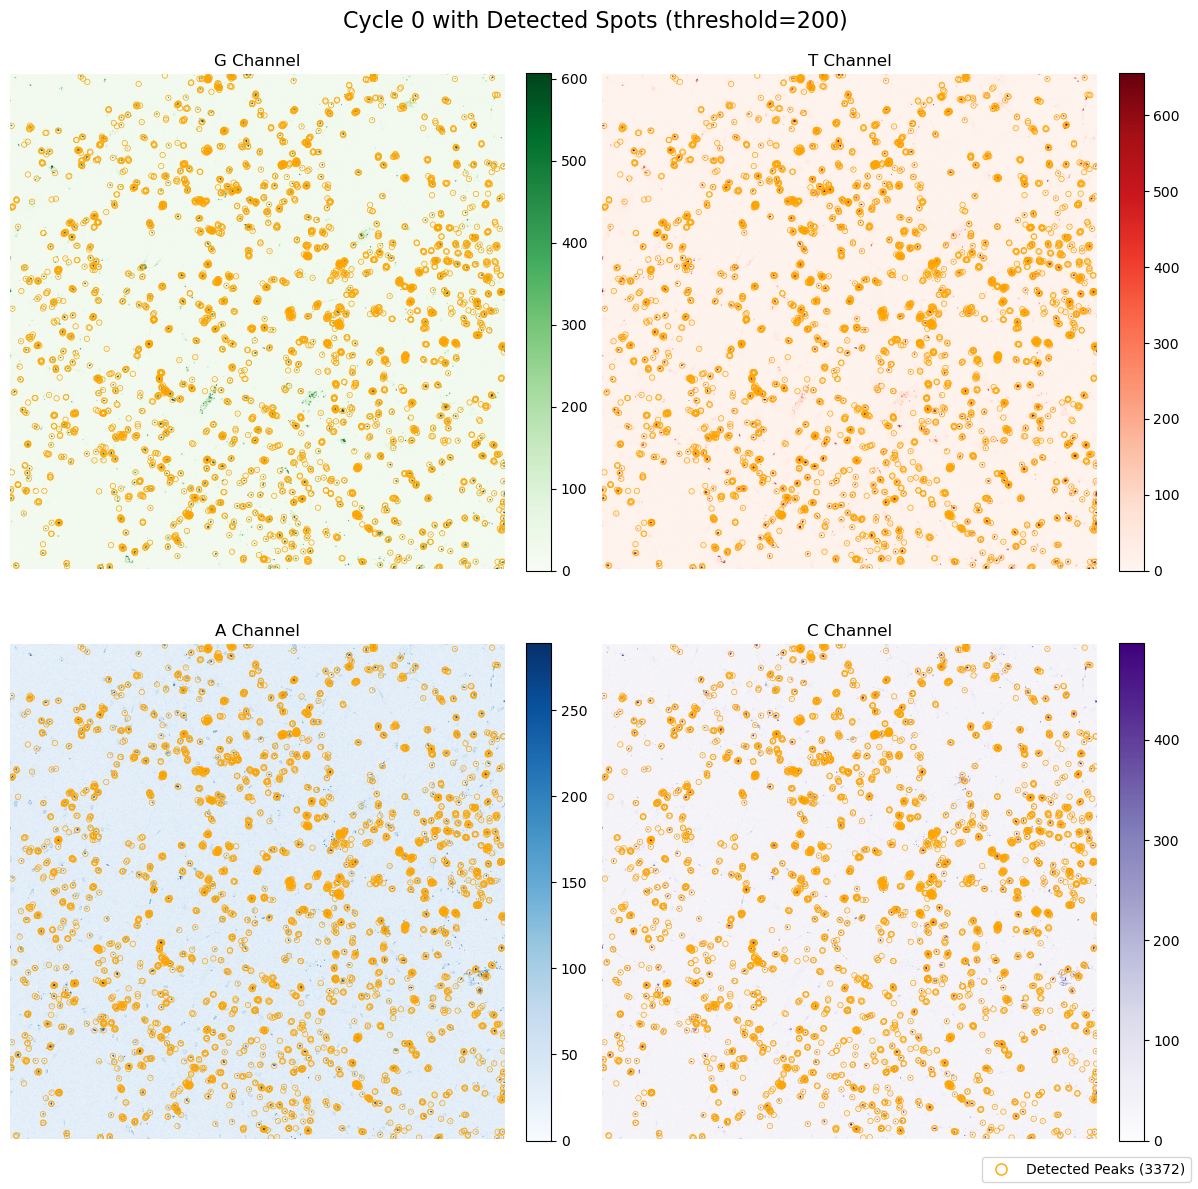

In [58]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=EXTRA_CHANNEL_INDICES)

print("Applying max filter...")
maxed = max_filter(loged, width=MAX_FILTER_WIDTH, remove_index=EXTRA_CHANNEL_INDICES)

if SPOT_DETECTION_METHOD == "standard":
    print("Computing standard deviation over cycles...")
    standard_deviation = compute_standard_deviation(loged, remove_index=EXTRA_CHANNEL_INDICES)
    
    print("Finding peaks using standard method...")
    peaks = find_peaks(standard_deviation, width=PEAK_WIDTH)
    
elif SPOT_DETECTION_METHOD == "spotiflow":
    print(f"Finding peaks using Spotiflow (model: {SPOTIFLOW_MODEL})...")
    peaks, _ = find_peaks_spotiflow(
        aligned_images=aligned, 
        cycle_idx=SPOTIFLOW_CYCLE_INDEX,
        model=SPOTIFLOW_MODEL,
        prob_thresh=SPOTIFLOW_THRESHOLD,
        min_distance=SPOTIFLOW_MIN_DISTANCE,
        verbose=True
    )

# Create and display micropanel of max filtered datas
print("Example max filtered image for first cycle:")
maxed_microimages = [
    Microimage(maxed[1, i, :, :], channel_names=BASES[i], cmaps=CHANNEL_CMAPS[i + 1])
    for i in range(maxed.shape[1])
]
maxed_panel = create_micropanel(maxed_microimages, add_channel_label=True)
plt.show()

# Plot spots on base channels
fig, axes = plot_channels_with_peaks(
    maxed,                 
    peaks,
    BASES,        
    cycle_number=0,   
    threshold_peaks=200 if SPOT_DETECTION_METHOD == "standard" else None,
    peak_colors=['orange'],
    peak_labels=['Detected Peaks']
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Illumination Correction and Segmentation

- `DAPI_CYCLE`: Cycle number where DAPI was imaged. Used for illumination correction of the DAPI channel.
- `CYTO_CYCLE`: Cycle number where the cytoplasmic/background channel was imaged. Used for illumination correction of the cytoplasmic channel.
- `CYTO_CHANNEL`: The name of the cytoplasmic channel used for cell boundary detection. 
  - When `DAPI_CYCLE == CYTO_CYCLE`: Can be any channel imaged in that cycle (e.g., "Vimentin", "GFP", "Phalloidin")
  - When `DAPI_CYCLE != CYTO_CYCLE`: Should be a base channel ("G", "T", "A", or "C") since DAPI was imaged separately

**Note**: Only set `DAPI_CYCLE != CYTO_CYCLE` when DAPI was imaged in a separate cycle from your cytoplasmic signal. This typically occurs when using a base channel (G, T, A, C) for cytoplasm detection because no cellular stain was available in the DAPI cycle.

In [63]:
# Define cycle to use for segmentation
DAPI_CYCLE = 1
CYTO_CYCLE = 1
# Define cytoplasmic channel
CYTO_CHANNEL = "C"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)
CYTO_CYCLE_INDEX = SBS_CYCLES.index(CYTO_CYCLE) - len([skip for skip in (SKIP_CYCLES or []) if skip < SBS_CYCLES.index(CYTO_CYCLE)])

# Validate DAPI and CYTO cycles and channels
if DAPI_CYCLE != CYTO_CYCLE and CYTO_CHANNEL not in BASES:
    raise ValueError(
        f"When DAPI_CYCLE ({DAPI_CYCLE}) != CYTO_CYCLE ({CYTO_CYCLE}), "
        f"CYTO_CHANNEL should be a base channel {BASES}, but got '{CYTO_CHANNEL}'. "
        f"If using a cellular stain, set DAPI_CYCLE = CYTO_CYCLE."
    )

In [64]:
# Determine the cycle to use for segmentation as the cyt
aligned_image_data_segmentation_cycle = aligned[CYTO_CYCLE_INDEX]

print("Applying illumination correction to segmentation cycle image...")

# Logic based on whether DAPI and CYTO come from same or different cycles
if DAPI_CYCLE != CYTO_CYCLE:
    # Different cycles - need to combine IC fields
    ic_field_dapi = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": DAPI_CYCLE}, "ic_field", "tiff")
    )
    ic_field_cyto = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": CYTO_CYCLE}, "ic_field", "tiff")
    )
    # Combine IC fields - need to figure out the right indices for combine_ic_images
    ic_field = combine_ic_images([ic_field_dapi, ic_field_cyto], [EXTRA_CHANNEL_INDICES, None])
else:
    # Same cycle - use one IC field
    ic_field = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": DAPI_CYCLE}, "ic_field", "tiff")
    )

# Apply illumination correction field
corrected_image = apply_ic_field(
    aligned_image_data_segmentation_cycle, correction=ic_field
)

# Prepare corrected image for CellPose segmentation
# NOTE: this process is done during the `segment_cellpose`` method below as well
# Use the prepared_cellpose image to test CellPose (see below)
print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = prepare_cellpose(
    corrected_image,
    DAPI_INDEX,
    CYTO_INDEX,
)

# show max filtered data for one round
print("Pre-segmentation images:")
pre_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(cellpose_rgb[1], channel_names="Cyto"),
]
pre_seg_panel = create_micropanel(pre_seg_microimages, add_channel_label=True)
plt.show()

Applying illumination correction to segmentation cycle image...


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tubhi/Documents/brieflow_output/preprocess/ic_fields/sbs/P-1_W-3_C-1__ic_field.tiff'

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", "stardist", or "watershed" for cell segmentation.

#### Common Parameters
- `GPU`: Set to True to use GPU acceleration (if available).
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing).
- `SEGMENT_CELLS`: Whether to segment cells, or only segment nuclei. If spots are contained in nuclei, there is no need to segment cell bodies. This may speed up analysis.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically, but can be manually overridden.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [ ]:
# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

# Common parameters
GPU = False
RECONCILE = "contained_in_cells"
SEGMENT_CELLS = False

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import estimate_diameters
    # Parameters for CellPose method
    CELLPOSE_MODEL = "nuclei"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1 
    CELL_CELLPROB_THRESHOLD = 0 

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

elif SEGMENTATION_METHOD == "watershed":
    # Parameters for Watershed method
    THRESHOLD_DAPI = 4260 
    THRESHOLD_CELL = 1300
    NUCLEUS_AREA = (45,450)

In [ ]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "watershed":
    from lib.shared.segment_watershed import segment_watershed
    nuclei, cells = segment_watershed(
        corrected_image,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        cell_threshold=THRESHOLD_CELL,
        cells=SEGMENT_CELLS,
    )

# Create and display micropanel of nuclei segmention
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(cellpose_rgb, channel_names="Merged"),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated data
print("Example microplot for sequencing data annotated with segmentation:")
annotated_data = image_segmentation_annotations(cellpose_rgb[1:], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data,
        channel_names="Merged",
        cmaps=["pure_blue", "pure_red", "pure_green"],
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Barcode design table standardization

Raw barcode design tables from different sources often have inconsistent formatting, column names, and gene annotations that need to be cleaned and validated before analysis. This standardization step transforms your raw design file into a consistent format with validated gene symbols, standardized column names, and proper barcode prefixes for read mapping. The standardization process includes: column renaming, duplicate removal, gene symbol validation against UniProt, non-targeting control standardization, and barcode prefix generation. The essential parameters below need to be set, with the four most critical parameters being `BARCODE_COL`, `GENE_SYMBOL_COL`, `GENE_ID_COL`, and `PREFIX_LENGTH`:

- `DF_DESIGN_FP`: File path to your raw guide RNA design file (TSV format).
- `DF_BARCODE_LIBRARY_FP`: File path where the cleaned, standardized barcode library will be saved. This is set to a standard file path.
- `UNIPROT_DATA_FP`: File path where UniProt annotation data is temporarily saved (automatically generated and deleted after use). The print statement will generate genes that do not have a UniProt identifier, which may require further manual review.
- `BARCODE_COL`: Column name containing barcode sequences in your design file (e.g., "sgRNA", "guide_sequence").
- `GENE_SYMBOL_COL`: Column name containing gene symbols in your design file (e.g., "gene_symbol", "target_gene"). Set to `None` if no gene information is available.
- `GENE_ID_COL`: Column name containing gene IDs in your design file (e.g., "gene_id", "ensembl_id"). Set to `None` if not available or not needed.
- `PREFIX_LENGTH`: Length of barcode prefixes for read mapping. This must match the length of your experimental read barcodes after any processing (e.g., 11 bases if cycle 1 was skipped, 12 bases if no cycles skipped). Prefixes are essential for SBS evaluation and cell calling. For complex scenarios like cycle skipping, use custom `prefix_func` instead.

**Note:**
For complex design files, you can also specify custom filtering functions, advanced prefix generation functions, non-targeting control patterns, and other processing options directly in the `standardize_barcode_design()` function call. Examples are contained in the source function documentation.

In [ ]:
# Define parameters for cleaning up barcode design table
DF_DESIGN_FP = None
DF_BARCODE_LIBRARY_FP = "config/barcode_library.tsv"
UNIPROT_DATA_FP = "config/uniprot_data.tsv"
BARCODE_COL = None
GENE_SYMBOL_COL = None
GENE_ID_COL = None
PREFIX_LENGTH = aligned.shape[0]

In [ ]:
# Get uniprot data and save it temporarily
uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
uniprot_data = pd.read_csv(UNIPROT_DATA_FP, sep="\t")

# Read and standardize guide data
print("Loading and standardizing barcode design table...")
df_design = pd.read_csv(DF_DESIGN_FP, sep="\t")

# Standardize the barcode design table
df_barcode_library = standardize_barcode_design(
    df_design,
    barcode_col=BARCODE_COL,
    gene_symbol_col=GENE_SYMBOL_COL,
    gene_id_col=GENE_ID_COL,
    uniprot_data_path=UNIPROT_DATA_FP,
    prefix_length=PREFIX_LENGTH,
)
# Delete uniprot data file
Path(UNIPROT_DATA_FP).unlink(missing_ok=True)

# Save standardized design table
df_barcode_library.to_csv(DF_BARCODE_LIBRARY_FP, sep="\t", index=False)
print(f"Standardized barcode design saved to: {DF_BARCODE_LIBRARY_FP}")
display(df_barcode_library)

# Extract barcodes (prefixes) for mapping
barcodes = get_barcode_list(df_barcode_library)
print(f"Extracted {len(barcodes)} barcode prefixes for read mapping")

## <font color='red'>SET PARAMETERS</font>

### Extract base intensity, call reads, assign to cells
- `THRESHOLD_READS`: Initial threshold for detecting sequencing reads, set to ~50 for preliminary analysis. This parameter will be optimized based on the mapping rate vs. peak threshold plot generated below. A higher threshold increases confidence in read calls but reduces the total number of detected reads.
- `CALL_READS_METHOD`: Method to use for correcting base intensity across channels. The below `plot_normalization_comparison` function will help you assess what method to use. Options are:
    - `MEDIAN`: Uses median-based correction, performed independently for each tile. This is the default method.
    - `PERCENTILE`: Uses percentile-based correction, performed independently for each tile.

In [ ]:
# Define parameters for calling reads
THRESHOLD_READS = 50
CALL_READS_METHOD = "median"

In [ ]:
# Run extract_bases and call_reads with the default threshold
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
df_reads = call_reads(df_bases, peaks_data=peaks, method=CALL_READS_METHOD)

The following plots will help determine the optimal `THRESHOLD_READS` value for your data:

In [ ]:
print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

#### Left Plot (All Reads):
- Shows how the peak threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid orange line: Total number of mapped spots (reads with valid barcodes)
- Dotted orange line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Setting Threshold Peaks:
Look for the point where the blue line (mapping rate) begins to plateau (~400)
- Consider the trade-off with number of mapped spots and cells
- A threshold around 300-500 typically provides a good balance:
  - Achieves ~75% mapping rate
  - Retains a reasonable number of mapped spots
  - Maintains coverage across cells

In [ ]:
THRESHOLD_READS = None

In [ ]:
# Re-run extract_bases and call_reads with the new threshold
print("Extracted bases:")
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(
    x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False
)
plt.show()

print("Different normalization methods")
plot_normalization_comparison(df_bases, base_order = BASES)

In [ ]:
print("Called reads:")
df_reads = call_reads(df_bases, peaks_data=peaks)
display(df_reads)

## <font color='red'>SET PARAMETERS</font>

### Read mapping

- `BARCODE_COL`: Column name in barcode library containing full barcode sequences. Used for dynamic prefix creation when `PREFIX_COL` is not specified. Default is `sgRNA`.
- `PREFIX_COL`: Column name in barcode library containing pre-computed barcode prefixes for read matching. If specified, these prefixes are used directly instead of creating them from `BARCODE_COL`. Use this for more complex scenarios (e.g. cycle-skipping) where custom prefixes were created in `standardize_barcode_design()`. Set to `None` to use dynamic prefix creation.
- `ERROR_CORRECT`: Whether to correct reads by comparing each read to the set of available reads. If error correction is needed, further parameters such as `MAX_DISTANCE` and `DISTANCE_METRIC` can be defined.
- `SORT_CALLS`: Method for prioritizing barcodes in each cell. Use `'count'` if multiple barcodes are expected per cell (e.g. using an mRNA identifier protocol) - prioritizes by read frequency. Use `'peak'` if one barcode per perturbation is expected per cell (e.g. using a DNA identifier protocol) - prioritizes by signal intensity. Default is `'count'`.
- `Q_MIN`: The minimum quality score for each base read. Calculated as 1 - [log2(2 + second) / log2(2 + first)]. Default is 0 and typically remains unchanged. While the Q_min plot above shows the relationship between Q_min and mapping rate, adjusting THRESHOLD_READS is the preferred method for quality control. Higher Q_min values are more stringent but can excessively filter valid reads.

The following plots will help determine the optimal `Q_MIN` value for your data:

In [ ]:
print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

#### Left Plot (All Reads):
- Shows how Q_min threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid red line: Total number of mapped spots (reads with valid barcodes)
- Dotted red line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Interpreting Q_min Results:
With our optimized peak threshold, these plots confirm that adjusting Q_min provides little benefit:
- The mapping rate (blue line) is already very high at Q_min = 0
- Increasing Q_min only marginally improves mapping rate 
- However, this comes at a significant cost:
  - Total mapped spots and mapped cells decreases substantially
- The small gain in mapping rate doesn't justify the large loss of data

In [ ]:
# Define parameters for read mapping
BARCODE_COL = "sgRNA"
PREFIX_COL = None
ERROR_CORRECT = False
Q_MIN = 0
SORT_CALLS = "count"

In [ ]:
print("Corrected cells:")
df_cells = call_cells(
    df_reads, 
    df_barcode_library=df_barcode_library, 
    q_min=Q_MIN, 
    barcode_col=BARCODE_COL, 
    prefix_col=PREFIX_COL, 
    error_correct=ERROR_CORRECT,
    sort_calls=SORT_CALLS,
)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = extract_phenotype_minimal(
    phenotype_data=nuclei, nuclei_data=nuclei, wildcards=WILDCARDS
)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="one",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="any",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_cell_metric_histogram(df_cells, sort_by=SORT_CALLS)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells)
plt.show()

## Add sbs process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_sbs_paramsearch` will systematically explore combinations of parameters for segmentation accuracy. This is not yet implemented.

In [ ]:
# Add sbs section
config["sbs"] = {
    "alignment_method": ALIGNMENT_METHOD,
    "channel_names": CHANNEL_NAMES,
    "upsample_factor": UPSAMPLE_FACTOR,
    "skip_cycles_indices": SKIP_CYCLES_INDICES,
    "manual_background_cycle_index": MANUAL_BACKGROUND_CYCLE_INDEX,
    "extra_channel_indices": EXTRA_CHANNEL_INDICES,
    "max_filter_width": MAX_FILTER_WIDTH,
    "spot_detection_method": SPOT_DETECTION_METHOD,
    "dapi_cycle": DAPI_CYCLE,
    "cyto_cycle": CYTO_CYCLE,
    "cyto_cycle_index": CYTO_CYCLE_INDEX,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "gpu": GPU,
    "reconcile": RECONCILE,
    "segment_cells": SEGMENT_CELLS,
    "df_barcode_library_fp": DF_BARCODE_LIBRARY_FP,
    "threshold_peaks": THRESHOLD_READS,
    "call_reads_method": CALL_READS_METHOD,
    "bases": BASES,
    "q_min": Q_MIN,
    "barcode_col": BARCODE_COL,
    "prefix_col": PREFIX_COL,
    "error_correct": ERROR_CORRECT,
    "sort_calls": SORT_CALLS,
    "mode": None,
}

# Add spot detection method specific parameters
if SPOT_DETECTION_METHOD == "standard":
    config["sbs"].update({
        "peak_width": PEAK_WIDTH,
    })
elif SPOT_DETECTION_METHOD == "spotiflow":
    config["sbs"].update({
        "spotiflow_cycle_index": SPOTIFLOW_CYCLE_INDEX,
        "spotiflow_model": SPOTIFLOW_MODEL,
        "spotiflow_threshold": SPOTIFLOW_THRESHOLD,
        "spotiflow_min_distance": SPOTIFLOW_MIN_DISTANCE,
    })

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["sbs"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["sbs"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["sbs"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })
elif SEGMENTATION_METHOD == "watershed":
    config["sbs"].update({
        "threshold_dapi": THRESHOLD_DAPI,
        "nucleus_area_min": NUCLEUS_AREA[0],
        "nucleus_area_max": NUCLEUS_AREA[1],
        "threshold_cell": THRESHOLD_CELL,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)